# Environmental Sound Classification

---
[Mattia Pujatti](mattia.pujatti.1@studenti.unipd.it), ID 1232236, master degree in Physics of Data

---

This notebook has been realized as final project for the course of Human Data Analytics, held by professors [Michele Rossi](rossi@dei.unipd.it) and [Francesca Meneghello](meneghello@dei.unipd.it), during the academic year 2019/2020 at the University of Padua.

###### [Introduction](#Introduction) | [Dataset](#The-Dataset) | [Audio Features](#Audio-Features) | [Repository content](#repository-content) | [License](#license) | [Citing](#citing) | [Caveats](#caveats) | [Changelog](#changelog)

## Introduction

*The main purpose of this notebook will be to provide an efficient way, using machine learning techniques, to classify environmental sound clips belonging to one of the only....several approaches will be tried, exploiting*

Most of the audio features that we are interested about for our classifier will be extracted from those clips exploiting the powerful and complete functions provided by the library [librosa](https://librosa.org/doc/latest/index.html), for Python.

In [40]:
# Requirements
import os
from tqdm.notebook import tqdm
import requests
import zipfile
import pydub
import numpy as np
import IPython
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd

## The Dataset

One of the main obstacle in research activities focused on environmental sound classification was the scarcity of large public dataset to exploit to train our networks. Luckily, a few years ago, thank to the work of Karol J. Piczak, form the University of Warsav, a set of 2000 recordings from the **[Freesound.org project](http://freesound.org/)**, representing 50 classes of various common sounds, were collected and correctly labeled, forming one the first accessible dataset for this kind of problems. A large number of papers have been written in the last years, each of them proposing a new and more efficient approach to classify those kind of clips, even surpassing the human classification accuracy. In this notebook we will try to do the same: first analyzing some of the audio features that we can extract from the tracks, that can be used to distinguish among various classes, and then implementing a multivariate analysis technique, like neural networks. 

The **ESC-50 dataset** is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories:

| <sub>Animals</sub> | <sub>Natural soundscapes & water sounds </sub> | <sub>Human, non-speech sounds</sub> | <sub>Interior/domestic sounds</sub> | <sub>Exterior/urban noises</sub> |
| :--- | :--- | :--- | :--- | :--- |
| <sub>Dog</sub> | <sub>Rain</sub> | <sub>Crying baby</sub> | <sub>Door knock</sub> | <sub>Helicopter</sub></sub> |
| <sub>Rooster</sub> | <sub>Sea waves</sub> | <sub>Sneezing</sub> | <sub>Mouse click</sub> | <sub>Chainsaw</sub> |
| <sub>Pig</sub> | <sub>Crackling fire</sub> | <sub>Clapping</sub> | <sub>Keyboard typing</sub> | <sub>Siren</sub> |
| <sub>Cow</sub> | <sub>Crickets</sub> | <sub>Breathing</sub> | <sub>Door, wood creaks</sub> | <sub>Car horn</sub> |
| <sub>Frog</sub> | <sub>Chirping birds</sub> | <sub>Coughing</sub> | <sub>Can opening</sub> | <sub>Engine</sub> |
| <sub>Cat</sub> | <sub>Water drops</sub> | <sub>Footsteps</sub> | <sub>Washing machine</sub> | <sub>Train</sub> |
| <sub>Hen</sub> | <sub>Wind</sub> | <sub>Laughing</sub> | <sub>Vacuum cleaner</sub> | <sub>Church bells</sub> |
| <sub>Insects (flying)</sub> | <sub>Pouring water</sub> | <sub>Brushing teeth</sub> | <sub>Clock alarm</sub> | <sub>Airplane</sub> |
| <sub>Sheep</sub> | <sub>Toilet flush</sub> | <sub>Snoring</sub> | <sub>Clock tick</sub> | <sub>Fireworks</sub> |
| <sub>Crow</sub> | <sub>Thunderstorm</sub> | <sub>Drinking, sipping</sub> | <sub>Glass breaking</sub> | <sub>Hand saw</sub> |

Clips in this dataset have been manually extracted from public field recordings gathered by the **[Freesound.org project](http://freesound.org/)**. The dataset has been prearranged into 5 folds for comparable cross-validation, making sure that fragments from the same original source file are contained in a single fold.

---

Directory content:

- `audio/*.wav`

  2000 audio recordings in WAV format (5 seconds, 44.1 kHz, mono) with the following naming convention:
  
  `{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav`
  
  - `{FOLD}` - index of the cross-validation fold,
  - `{CLIP_ID}` - ID of the original Freesound clip,
  - `{TAKE}` - letter disambiguating between different fragments from the same Freesound clip,
  - `{TARGET}` - class in numeric format [0, 49].

- `meta/esc50.csv`

  CSV file with the following structure containing the labels of the clips:
  
  | <sub>filename</sub> | <sub>fold</sub> | <sub>target</sub> | <sub>category</sub> | <sub>esc10</sub> | <sub>src_file</sub> | <sub>take</sub> |
  | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
  
  The `esc10` column indicates if a given file belongs to the *ESC-10* subset (another version of this dataset with 10 selected classes). 

---

A more thorough description of the dataset is available in the original [paper](http://karol.piczak.com/papers/Piczak2015-ESC-Dataset.pdf) , while the main folder of the project can be found on [github](https://github.com/karolpiczak/ESC-50).

Let's check if the dataset has already been downloaded and is present in the working directory: if not, the zip file available [here](https://github.com/karolpiczak/ESC-50) will be downloaded and extracted in a folder named "ESC-50-master". If the zip file is already present, then it is extracted as well if the folder does not exists yet.

In [15]:
direct_download_link = "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [34]:
def get_data(url):
    """ Download the zip datafile from the direct download link, generating the folder containing the audio files,
    the metadata and some old analysis. The function checks first if the file already exists, and if it is 
    of the correct dimension, if not, it will be deleted and re-downloaded. If the zip file is already present 
    but not extracted, il will be. """
    
    zipfilename = 'ESC-50-master.zip'
    dirname = 'ESC-50-master'

    # Check the dimension of the file
    
    # Many times apparently the connection is not complete, so we repeat until success
    total_size = None
    while total_size==None:
        try:         # connect
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('Content-Length')) # in bytes
        except:
            response.close()
    
    if (abs(os.path.getsize(zipfilename) - total_size) > 1024*1024): # checking the difference to be at most 1MB
        os.remove(zipfilename)
    # Check if the data folder already exists
    if not os.path.exists(dirname):
        # Check if the zip file has already been downloaded
        if not os.path.exists(zipfilename):
            # Download the file from the direct link reported above
            with open(zipfilename, 'wb') as f: 
                with tqdm(total=total_size, unit='B', unit_scale=True, unit_divisor=1024, 
                          desc='Downloading the file...') as pbar:        
                    for data in response.iter_content(32*1024):            
                        f.write(data)
                        pbar.update(len(data))
        # Unzip the file
        with zipfile.ZipFile(zipfilename) as zf:
            for member in tqdm(zf.infolist(), desc='Unzipping the file...'):
                try:
                    zf.extract(member, dirname)
                except zipfile.error as e:
                    pass        
    response.close()

In [35]:
get_data(direct_download_link)

Unzipping the file...:   0%|          | 0/2017 [00:00<?, ?it/s]

In [36]:
# Download or extract the dataset
get_data(direct_download_link)

# In the folder just downloaded there is a sub-directory "audio" that contains 
# all the audio file that we are going to analyze.
audio_dir = os.getcwd() + '/ESC-50-master' + '/ESC-50-master' + '/audio/'

In [65]:
# Since the labels are represented by a numerical class in [0-49], it would be nice to have a way to
# associate the name of the class to the label.
label_map = {}
label_df = pd.read_csv(os.getcwd()+'/ESC-50-master/ESC-50-master/meta/esc50.csv')
for i in range(50):
    label_map[i] = df.loc[df["target"]==i, "category"].unique()[0]

## Audio Features

Define a class in order to handle and manipulate audio files:

- `Class Audio`: the subclass that effectively store the audio track, cutting or padding it with zeros if it is not 5.0s long, and with two functions `__enter__` and `__exit__` that allow for a more efficient memory handling, keeping the raw clip only the time necessary to extract its features;

- `__init__`: the constructor of the main Clip class, it takes in input the path of the clip we are analyzing and the corresponding label;

- `Play`: plays the audio in the clip;

- `DisplayWave`: plot the raw signal stored in the clip;

- `DisplaySpectrogram`: plot the spectrogram of raw signal stored in the clip;

*Describe features*

In [75]:
class Clip():
    """"""
    
    class Audio:
        """ The actual audio data of the clip.
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage, keeping just the 
            features computed but not the entire sound vector.
        """
        
        def __init__(self, path):
            self.path = path
            self.timelength = 5.0
        
        def __enter__(self):
            # In order to prevent having clips longer or smaller than 5 seconds
            self.data, self.rate = librosa.load(self.path, sr=None, duration=self.timelength)
            rawaudiosize = self.timelength*self.rate
            if self.data.shape[0] < rawaudiosize:
                self.raw = np.pad(self.data, pad_width=(0,rawaudiosize-len(self.data)), 
                                   mode='constant', constant_values=0.)
            else:
                self.raw = self.data
                
            return self
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
            
            
            
    def __init__(self, path, label_map):
        self.clipname = os.path.basename(path)
        self.path = path
        
        self.fold = int(self.clipname.split('-')[0])
        self.clipID = int(self.clipname.split('-')[1])
        self.take = self.clipname.split('-')[2]
        self.target = int(self.clipname.split('-')[3].split('.')[0])
        self.category = label_map[self.target]
        
        self.audio = Clip.Audio(self.path)
        

    def Compute_Features(self, features_list):
        """ Exploit the functions provided by the librosa library to compute several audio analysis
        features. Available:
        * spectral centroid
        * spectral rolloff
        * spectral bandwidth
        * zero-crossing rate
        * mfcc
        * delta
        If the input values is "all" -> compute all the features listed above
        """
        if features_list == "all": 
            features_list = ["spectral centroid", "spectral rolloff", "spectral bandwidth", "zero-crossing rate", "mfcc", "delta"]
        self.features = {}
        
        with self.audio as audio:
            if "spectral centroid" in features_list:
                self.features["spectral centroid"] = librosa.feature.spectral_centroid(audio.raw, sr=audio.rate)[0]
            if "spectral rolloff" in features_list:
                self.features["spectral rolloff"] = librosa.feature.spectral_rolloff(audio.raw, sr=audio.rate)[0]
            if "spectral bandwidth" in features_list:
                self.features["spectral bandwidth"] = librosa.feature.spectral_bandwidth(audio.raw, sr=audio.rate, p=2)[0]
            if "zero-crossing rate" in features_list:
                self.features["zero-crossing rate"] = librosa.feature.zero_crossing_rate(audio.raw, pad=False)
            if "mfcc" in features_list:
                self.features["mfcc"] = librosa.feature.mfcc(audio.raw, sr=audio.rate, n_mfcc=13)
            if "delta" in features_list:
                if "mfcc" not in self.features: self.features["mfcc"] = librosa.feature.mfcc(audio.raw, sr=audio.rate)
                self.features["delta"] = librosa.feature.delta(self.features["mfcc"])
        return 
            
        
    def Play(self):
        """ Exploit the functionality of IPython to run the audio of the clip """
        with self.audio as audio:
            play = IPython.display.Audio(audio.data, rate=audio.rate)
        return play
            
    def DisplayWave(self):
        """ Plot the raw signal stored in the clip """
        with self.audio as audio:
            _, ax = plt.subplots(1,1, figsize=(8,3))
            librosa.display.waveplot(y=audio.raw, sr=audio.rate, ax=ax, alpha=0.4)
            ax.set_title(self.category + ' - ' + self.clipname)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
        return ax
    
    def DisplaySpectrogram(self):
        """ Plot the spectrogram of raw signal stored in the clip """
        with self.audio as audio:
            X = librosa.stft(audio.raw)
            Xdb = librosa.amplitude_to_db(abs(X))
            _, ax = plt.subplots(1,1, figsize=(9,3))
            ss = librosa.display.specshow(Xdb, sr=audio.rate, x_axis='time', y_axis='log', cmap='RdBu_r')
            plt.colorbar(ss)
            ax.set_title(self.category + ' - ' + self.clipname)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
        return ax

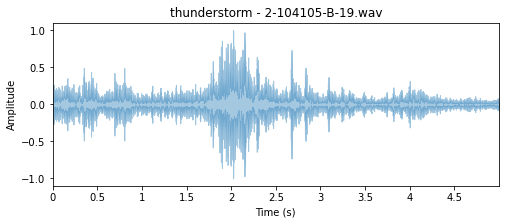

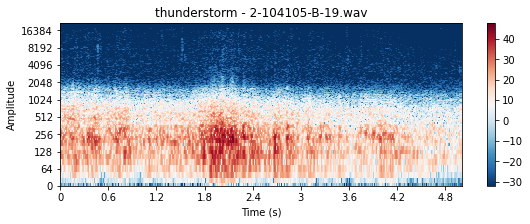

In [81]:
Clip(audio_dir + '2-104105-B-19.wav', label_map).Play()
Clip(audio_dir + '2-104105-B-19.wav', label_map).DisplayWave()
Clip(audio_dir + '2-104105-B-19.wav', label_map).DisplaySpectrogram();

In [ ]:
testclip = Clip(audio_dir + '2-104105-B-19.wav')
testclip.Compute_Features("all")

In [ ]:
testclip.features["mfcc"]

In [ ]:
x, sr = librosa.load(audio_dir + '2-104105-B-19.wav', sr=None, duration=5.0)
plt.figure(figsize=(14,5))
librosa.display.waveplot(x, sr)

In [ ]:
def load_dataset(data_dir):
    clips = []
    for file in sorted(os.listdir(data_dir)):
        clips.append(Clip(data_dir + file))
    return clips
        
data = load_dataset(audio_dir)
len(data)